# Fine-tuning Whisper on Speech Pathology Dataset



## Goal

The goal of the Cleft Palate project  at Vanderbilt DSI is to classify audio clips of patients' voices as containing hypernasality (a speech impediment) or not. The patients with hypernasality can then be recommended for speech pathology intervention. This is currently evaluated by human speech pathologists, which requires access to these medical providers. Our hope is to train a model that can classify this speech impediment for expedited patient access to a speech pathologist.

Tutorial created with guidance from ["Fine Tuning OpenAI Whisper Model for Audio Classifcation in PyTorch"](https://www.daniweb.com/programming/computer-science/tutorials/540802/fine-tuning-openai-whisper-model-for-audio-classification-in-pytorch)

## Model

We plan to use the Whisper embedings from OpenAI and train a classification model, either using Whisper with a sequence classification head or another classification LLM.

## Data

The data in this notebook is publicly available voice recordings featuring hypernasality and control groups. In the future we hope to train our model on private patient data from Vanderbilt University Medical Center (VUMC).

In [ ]:
!pip install torch
!pip install datasets
!pip install librosa
!pip install transformers

from google.colab import drive
# Mount Google Drive
import random
drive.mount('/content/drive')

# import libraries
import datasets
from datasets import load_dataset, DatasetDict,  Audio
import pandas as pd
import os
import glob
import librosa
import io
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, accuracy_score
from transformers import WhisperModel, WhisperFeatureExtractor, AdamW
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from sklearn.metrics import f1_score, classification_report, accuracy_score


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
data_path = "/workspace/cleft_palate_choja/WAV_PUBLIC_SAMPLES/NOISE"

train_catalog = "/workspace/cleft_palate_choja/train_noise.csv"
test_catalog = "/workspace/cleft_palate_choja/test_noise.csv"

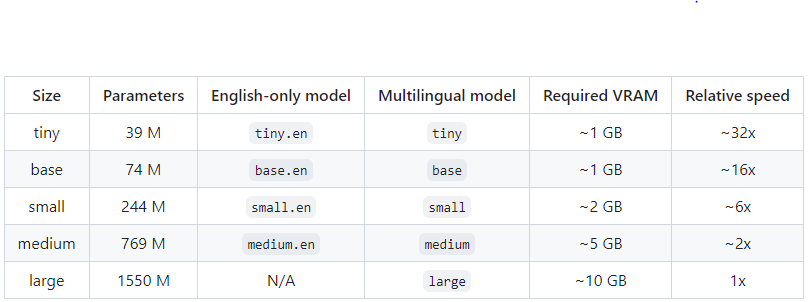

# ==================================================================================================================
# Tiny

In [ ]:
model_checkpoint = "openai/whisper-tiny"

train_metadata = pd.read_csv(train_catalog)
train_df, val_df = train_test_split(train_metadata, test_size = 0.3, random_state = 42)
train_files = train_df["WAV_filename"].tolist()
train_folder = train_df["WAV_folder"].tolist()
train_full_paths = [os.path.join(data_path,train_folder[i], train_files[i]) for i in range(0,len(train_files))]
train_labels = train_df["hypernasality"].tolist()
# val set
val_files = val_df["WAV_filename"].tolist()

val_folder = val_df["WAV_folder"].tolist()

val_full_paths = [os.path.join(data_path,val_folder[i], val_files[i]) for i in range(0,len(val_files))]

val_labels = val_df["hypernasality"].tolist()

test_metadata = pd.read_csv(test_catalog)
# add cols for wav data

# Replace ".mp3" with ".wav" in the "Filename" column
test_metadata['WAV_filename'] = test_metadata['File_Name'].str.replace('.mp3', '.wav')

# Create "WAV_folder" column by concatenating "_WAV" to the "folder" column
test_metadata['WAV_folder'] = test_metadata['folder'] + "_WAV"

test_files = test_metadata["WAV_filename"].tolist()

test_folder = test_metadata["WAV_folder"].tolist()

test_full_paths = [os.path.join(data_path,test_folder[i], test_files[i]) for i in range(0,len(test_files))]

#test_full_paths

test_labels = test_metadata["hypernasality"].tolist()

train_audio_dataset = datasets.Dataset.from_dict({"audio": train_full_paths,
                                                  "labels":train_labels}
                                                 ).cast_column("audio", Audio(sampling_rate=16_000))
test_audio_dataset = datasets.Dataset.from_dict({"audio": test_full_paths,
                                                  "labels": test_labels}
                                                 ).cast_column("audio", Audio(sampling_rate=16_000))
val_audio_dataset = datasets.Dataset.from_dict({"audio": val_full_paths,
                                                 "labels": val_labels }
                                             ).cast_column("audio", Audio(sampling_rate=16_000))
#model_checkpoint = "openai/whisper-base"

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_checkpoint)
encoder = WhisperModel.from_pretrained(model_checkpoint)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class SpeechClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, audio_data,  text_processor):
        self.audio_data = audio_data
        self.text_processor = text_processor

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, index):

      inputs = self.text_processor(self.audio_data[index]["audio"]["array"],
                                   return_tensors="pt",
                                   sampling_rate=self.audio_data[index]["audio"]["sampling_rate"])
      input_features = inputs.input_features
      decoder_input_ids = torch.tensor([[1, 1]]) * encoder.config.decoder_start_token_id

      labels = np.array(self.audio_data[index]['labels'])

      return input_features, decoder_input_ids, torch.tensor(labels)
train_dataset = SpeechClassificationDataset(train_audio_dataset,  feature_extractor)
test_dataset = SpeechClassificationDataset(test_audio_dataset,  feature_extractor)
val_dataset = SpeechClassificationDataset(val_audio_dataset,  feature_extractor)

batch_size = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class SpeechClassifier(nn.Module):
    def __init__(self, num_labels, encoder):
        super(SpeechClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Linear(self.encoder.config.hidden_size, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_labels)
        )

    def forward(self, input_features, decoder_input_ids):
        outputs = self.encoder(input_features, decoder_input_ids=decoder_input_ids)
        pooled_output = outputs['last_hidden_state'][:, 0, :]
        logits = self.classifier(pooled_output)
        return logits
num_labels = 2

model = SpeechClassifier(num_labels, encoder).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, betas=(0.9, 0.999), eps=1e-08)
criterion = nn.CrossEntropyLoss()
# Define the training function NO VAL
def train(model, train_loader, optimizer, criterion, device, num_epochs):

  for epoch in range(num_epochs):

    model.train()

    for i, batch in enumerate(train_loader):

          input_features, decoder_input_ids, labels = batch

          input_features = input_features.squeeze()
          input_features = input_features.to(device)

          decoder_input_ids = decoder_input_ids.squeeze()
          decoder_input_ids = decoder_input_ids.to(device)

          labels = labels.view(-1)
          labels = labels.type(torch.LongTensor)
          labels = labels.to(device)

          optimizer.zero_grad()

          logits = model(input_features, decoder_input_ids)

          loss = criterion(logits, labels)
          loss.backward()

          optimizer.step()

          if (i+1) % 8 == 0:
              print(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, Train Loss: {loss.item():.4f}')

    torch.save(model.state_dict(), 'best_model.pt')
# Define the training function
def train(model, train_loader, val_loader, optimizer,  criterion, device, num_epochs):
    best_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        for i, batch in enumerate(train_loader):
            input_features, decoder_input_ids, labels = batch
            input_features = input_features.squeeze()
            input_features = input_features.to(device)
            decoder_input_ids = decoder_input_ids.squeeze()
            decoder_input_ids = decoder_input_ids.to(device)
            labels = labels.view(-1)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            optimizer.zero_grad()
            logits = model(input_features, decoder_input_ids)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            if (i+1) % 8 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, Train Loss: {loss.item() :.4f}')
                train_loss = 0.0
        val_loss, val_accuracy, val_f1, _ , _ = evaluate(model, val_loader, device)
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pt')
        print("========================================================================================")
        print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}, Best Accuracy: {best_accuracy:.4f}')
        print("========================================================================================")
def evaluate(model, data_loader,  device):
    all_labels = []
    all_preds = []
    total_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
          input_features, decoder_input_ids, labels = batch
          input_features = input_features.squeeze()
          input_features = input_features.to(device)
          decoder_input_ids = decoder_input_ids.squeeze()
          decoder_input_ids = decoder_input_ids.to(device)
          labels = labels.view(-1)
          labels = labels.type(torch.LongTensor)
          labels = labels.to(device)
          optimizer.zero_grad()
          logits = model(input_features, decoder_input_ids)
          loss = criterion(logits, labels)
          total_loss += loss.item()
          _, preds = torch.max(logits, 1)
          all_labels.append(labels.cpu().numpy())
          all_preds.append(preds.cpu().numpy())
    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)
    loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return loss, accuracy, f1, all_labels, all_preds

#TRAINING
print("================")
print("Training\n")

import librosa
num_epochs = 5
train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs)



#VALIDATION
state_dict = torch.load('best_model.pt')

# Create a new instance of the model and load the state dictionary
num_labels = 2
model = SpeechClassifier(num_labels, encoder).to(device)
model.load_state_dict(state_dict)

_, _, _, all_labels, all_preds = evaluate(model, val_loader, device)

#VALIDATION
print("\n\n")
print("================")
print("Validtation\n\n")
print(classification_report(all_labels, all_preds))
print(accuracy_score(all_labels, all_preds))

# TESTING ONLY
state_dict = torch.load('best_model.pt')

# Create a new instance of the model and load the state dictionary
num_labels = 2
model = SpeechClassifier(num_labels, encoder).to(device)
model.load_state_dict(state_dict)

_, _, _, all_labels, all_preds = evaluate(model, test_loader, device)

print("================")
print("Testing\n\n")
print(classification_report(all_labels, all_preds))
print(accuracy_score(all_labels, all_preds))

/tmp/ipykernel_1944/3453226131.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  test_metadata['WAV_filename'] = test_metadata['File_Name'].str.replace('.mp3', '.wav')
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training

Epoch 1/5, Batch 8/41, Train Loss: 0.7262
Epoch 1/5, Batch 16/41, Train Loss: 0.5654
Epoch 1/5, Batch 24/41, Train Loss: 0.4667
Epoch 1/5, Batch 32/41, Train Loss: 0.9074
Epoch 1/5, Batch 40/41, Train Loss: 0.4750
Epoch 1/5, Val Loss: 0.2922, Val Accuracy: 0.9438, Val F1: 0.9428, Best Accuracy: 0.9438
Epoch 2/5, Batch 8/41, Train Loss: 0.2944
Epoch 2/5, Batch 16/41, Train Loss: 0.2388
Epoch 2/5, Batch 24/41, Train Loss: 0.2523
Epoch 2/5, Batch 32/41, Train Loss: 0.0043
Epoch 2/5, Batch 40/41, Train Loss: 0.0159
Epoch 2/5, Val Loss: 0.0795, Val Accuracy: 0.9775, Val F1: 0.9775, Best Accuracy: 0.9775
Epoch 3/5, Batch 8/41, Train Loss: 0.0017
Epoch 3/5, Batch 16/41, Train Loss: 0.0017
Epoch 3/5, Batch 24/41, Train Loss: 0.0025
Epoch 3/5, Batch 32/41, Train Loss: 0.4147
Epoch 3/5, Batch 40/41, Train Loss: 0.0087
Epoch 3/5, Val Loss: 0.4051, Val Accuracy: 0.8876, Val F1: 0.8875, Best Accuracy: 0.9775
Epoch 4/5, Batch 8/41, Train Loss: 0.0042
Epoch 4/5, Batch 16/41, Train Loss: 0.0

#==================================================================================================================
# Base

In [ ]:
model_checkpoint = "openai/whisper-base"

train_metadata = pd.read_csv(train_catalog)
train_df, val_df = train_test_split(train_metadata, test_size = 0.3, random_state = 42)
train_files = train_df["WAV_filename"].tolist()
train_folder = train_df["WAV_folder"].tolist()
train_full_paths = [os.path.join(data_path,train_folder[i], train_files[i]) for i in range(0,len(train_files))]
train_labels = train_df["hypernasality"].tolist()
# val set
val_files = val_df["WAV_filename"].tolist()

val_folder = val_df["WAV_folder"].tolist()

val_full_paths = [os.path.join(data_path,val_folder[i], val_files[i]) for i in range(0,len(val_files))]

val_labels = val_df["hypernasality"].tolist()

test_metadata = pd.read_csv(test_catalog)
# add cols for wav data

# Replace ".mp3" with ".wav" in the "Filename" column
test_metadata['WAV_filename'] = test_metadata['File_Name'].str.replace('.mp3', '.wav')

# Create "WAV_folder" column by concatenating "_WAV" to the "folder" column
test_metadata['WAV_folder'] = test_metadata['folder'] + "_WAV"

test_files = test_metadata["WAV_filename"].tolist()

test_folder = test_metadata["WAV_folder"].tolist()

test_full_paths = [os.path.join(data_path,test_folder[i], test_files[i]) for i in range(0,len(test_files))]

#test_full_paths

test_labels = test_metadata["hypernasality"].tolist()

train_audio_dataset = datasets.Dataset.from_dict({"audio": train_full_paths,
                                                  "labels":train_labels}
                                                 ).cast_column("audio", Audio(sampling_rate=16_000))
test_audio_dataset = datasets.Dataset.from_dict({"audio": test_full_paths,
                                                  "labels": test_labels}
                                                 ).cast_column("audio", Audio(sampling_rate=16_000))
val_audio_dataset = datasets.Dataset.from_dict({"audio": val_full_paths,
                                                 "labels": val_labels }
                                             ).cast_column("audio", Audio(sampling_rate=16_000))
#model_checkpoint = "openai/whisper-base"

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_checkpoint)
encoder = WhisperModel.from_pretrained(model_checkpoint)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class SpeechClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, audio_data,  text_processor):
        self.audio_data = audio_data
        self.text_processor = text_processor

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, index):

      inputs = self.text_processor(self.audio_data[index]["audio"]["array"],
                                   return_tensors="pt",
                                   sampling_rate=self.audio_data[index]["audio"]["sampling_rate"])
      input_features = inputs.input_features
      decoder_input_ids = torch.tensor([[1, 1]]) * encoder.config.decoder_start_token_id

      labels = np.array(self.audio_data[index]['labels'])

      return input_features, decoder_input_ids, torch.tensor(labels)
train_dataset = SpeechClassificationDataset(train_audio_dataset,  feature_extractor)
test_dataset = SpeechClassificationDataset(test_audio_dataset,  feature_extractor)
val_dataset = SpeechClassificationDataset(val_audio_dataset,  feature_extractor)

batch_size = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class SpeechClassifier(nn.Module):
    def __init__(self, num_labels, encoder):
        super(SpeechClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Linear(self.encoder.config.hidden_size, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_labels)
        )

    def forward(self, input_features, decoder_input_ids):
        outputs = self.encoder(input_features, decoder_input_ids=decoder_input_ids)
        pooled_output = outputs['last_hidden_state'][:, 0, :]
        logits = self.classifier(pooled_output)
        return logits
num_labels = 2

model = SpeechClassifier(num_labels, encoder).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, betas=(0.9, 0.999), eps=1e-08)
criterion = nn.CrossEntropyLoss()
# Define the training function NO VAL
def train(model, train_loader, optimizer, criterion, device, num_epochs):

  for epoch in range(num_epochs):

    model.train()

    for i, batch in enumerate(train_loader):

          input_features, decoder_input_ids, labels = batch

          input_features = input_features.squeeze()
          input_features = input_features.to(device)

          decoder_input_ids = decoder_input_ids.squeeze()
          decoder_input_ids = decoder_input_ids.to(device)

          labels = labels.view(-1)
          labels = labels.type(torch.LongTensor)
          labels = labels.to(device)

          optimizer.zero_grad()

          logits = model(input_features, decoder_input_ids)

          loss = criterion(logits, labels)
          loss.backward()

          optimizer.step()

          if (i+1) % 8 == 0:
              print(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, Train Loss: {loss.item():.4f}')

    torch.save(model.state_dict(), 'best_model.pt')
# Define the training function
def train(model, train_loader, val_loader, optimizer,  criterion, device, num_epochs):
    best_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        for i, batch in enumerate(train_loader):
            input_features, decoder_input_ids, labels = batch
            input_features = input_features.squeeze()
            input_features = input_features.to(device)
            decoder_input_ids = decoder_input_ids.squeeze()
            decoder_input_ids = decoder_input_ids.to(device)
            labels = labels.view(-1)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            optimizer.zero_grad()
            logits = model(input_features, decoder_input_ids)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            if (i+1) % 8 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, Train Loss: {loss.item() :.4f}')
                train_loss = 0.0
        val_loss, val_accuracy, val_f1, _ , _ = evaluate(model, val_loader, device)
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pt')
        print("========================================================================================")
        print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}, Best Accuracy: {best_accuracy:.4f}')
        print("========================================================================================")
def evaluate(model, data_loader,  device):
    all_labels = []
    all_preds = []
    total_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
          input_features, decoder_input_ids, labels = batch
          input_features = input_features.squeeze()
          input_features = input_features.to(device)
          decoder_input_ids = decoder_input_ids.squeeze()
          decoder_input_ids = decoder_input_ids.to(device)
          labels = labels.view(-1)
          labels = labels.type(torch.LongTensor)
          labels = labels.to(device)
          optimizer.zero_grad()
          logits = model(input_features, decoder_input_ids)
          loss = criterion(logits, labels)
          total_loss += loss.item()
          _, preds = torch.max(logits, 1)
          all_labels.append(labels.cpu().numpy())
          all_preds.append(preds.cpu().numpy())
    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)
    loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return loss, accuracy, f1, all_labels, all_preds

#TRAINING
print("================")
print("Training\n")

import librosa
num_epochs = 5
train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs)



#VALIDATION
state_dict = torch.load('best_model.pt')

# Create a new instance of the model and load the state dictionary
num_labels = 2
model = SpeechClassifier(num_labels, encoder).to(device)
model.load_state_dict(state_dict)

_, _, _, all_labels, all_preds = evaluate(model, val_loader, device)

#VALIDATION
print("\n\n")
print("================")
print("Validtation\n\n")
print(classification_report(all_labels, all_preds))
print(accuracy_score(all_labels, all_preds))

# TESTING ONLY
state_dict = torch.load('best_model.pt')

# Create a new instance of the model and load the state dictionary
num_labels = 2
model = SpeechClassifier(num_labels, encoder).to(device)
model.load_state_dict(state_dict)

_, _, _, all_labels, all_preds = evaluate(model, test_loader, device)

print("================")
print("Testing\n\n")
print(classification_report(all_labels, all_preds))
print(accuracy_score(all_labels, all_preds))

# ==================================================================================================================
# Small

In [ ]:
model_checkpoint = "openai/whisper-small"

train_metadata = pd.read_csv(train_catalog)
train_df, val_df = train_test_split(train_metadata, test_size = 0.3, random_state = 42)
train_files = train_df["WAV_filename"].tolist()
train_folder = train_df["WAV_folder"].tolist()
train_full_paths = [os.path.join(data_path,train_folder[i], train_files[i]) for i in range(0,len(train_files))]
train_labels = train_df["hypernasality"].tolist()
# val set
val_files = val_df["WAV_filename"].tolist()

val_folder = val_df["WAV_folder"].tolist()

val_full_paths = [os.path.join(data_path,val_folder[i], val_files[i]) for i in range(0,len(val_files))]

val_labels = val_df["hypernasality"].tolist()

test_metadata = pd.read_csv(test_catalog)
# add cols for wav data

# Replace ".mp3" with ".wav" in the "Filename" column
test_metadata['WAV_filename'] = test_metadata['File_Name'].str.replace('.mp3', '.wav')

# Create "WAV_folder" column by concatenating "_WAV" to the "folder" column
test_metadata['WAV_folder'] = test_metadata['folder'] + "_WAV"

test_files = test_metadata["WAV_filename"].tolist()

test_folder = test_metadata["WAV_folder"].tolist()

test_full_paths = [os.path.join(data_path,test_folder[i], test_files[i]) for i in range(0,len(test_files))]

#test_full_paths

test_labels = test_metadata["hypernasality"].tolist()

train_audio_dataset = datasets.Dataset.from_dict({"audio": train_full_paths,
                                                  "labels":train_labels}
                                                 ).cast_column("audio", Audio(sampling_rate=16_000))
test_audio_dataset = datasets.Dataset.from_dict({"audio": test_full_paths,
                                                  "labels": test_labels}
                                                 ).cast_column("audio", Audio(sampling_rate=16_000))
val_audio_dataset = datasets.Dataset.from_dict({"audio": val_full_paths,
                                                 "labels": val_labels }
                                             ).cast_column("audio", Audio(sampling_rate=16_000))
#model_checkpoint = "openai/whisper-base"

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_checkpoint)
encoder = WhisperModel.from_pretrained(model_checkpoint)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class SpeechClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, audio_data,  text_processor):
        self.audio_data = audio_data
        self.text_processor = text_processor

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, index):

      inputs = self.text_processor(self.audio_data[index]["audio"]["array"],
                                   return_tensors="pt",
                                   sampling_rate=self.audio_data[index]["audio"]["sampling_rate"])
      input_features = inputs.input_features
      decoder_input_ids = torch.tensor([[1, 1]]) * encoder.config.decoder_start_token_id

      labels = np.array(self.audio_data[index]['labels'])

      return input_features, decoder_input_ids, torch.tensor(labels)
train_dataset = SpeechClassificationDataset(train_audio_dataset,  feature_extractor)
test_dataset = SpeechClassificationDataset(test_audio_dataset,  feature_extractor)
val_dataset = SpeechClassificationDataset(val_audio_dataset,  feature_extractor)

batch_size = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class SpeechClassifier(nn.Module):
    def __init__(self, num_labels, encoder):
        super(SpeechClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Linear(self.encoder.config.hidden_size, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_labels)
        )

    def forward(self, input_features, decoder_input_ids):
        outputs = self.encoder(input_features, decoder_input_ids=decoder_input_ids)
        pooled_output = outputs['last_hidden_state'][:, 0, :]
        logits = self.classifier(pooled_output)
        return logits
num_labels = 2

model = SpeechClassifier(num_labels, encoder).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, betas=(0.9, 0.999), eps=1e-08)
criterion = nn.CrossEntropyLoss()
# Define the training function NO VAL
def train(model, train_loader, optimizer, criterion, device, num_epochs):

  for epoch in range(num_epochs):

    model.train()

    for i, batch in enumerate(train_loader):

          input_features, decoder_input_ids, labels = batch

          input_features = input_features.squeeze()
          input_features = input_features.to(device)

          decoder_input_ids = decoder_input_ids.squeeze()
          decoder_input_ids = decoder_input_ids.to(device)

          labels = labels.view(-1)
          labels = labels.type(torch.LongTensor)
          labels = labels.to(device)

          optimizer.zero_grad()

          logits = model(input_features, decoder_input_ids)

          loss = criterion(logits, labels)
          loss.backward()

          optimizer.step()

          if (i+1) % 8 == 0:
              print(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, Train Loss: {loss.item():.4f}')

    torch.save(model.state_dict(), 'best_model.pt')
# Define the training function
def train(model, train_loader, val_loader, optimizer,  criterion, device, num_epochs):
    best_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        for i, batch in enumerate(train_loader):
            input_features, decoder_input_ids, labels = batch
            input_features = input_features.squeeze()
            input_features = input_features.to(device)
            decoder_input_ids = decoder_input_ids.squeeze()
            decoder_input_ids = decoder_input_ids.to(device)
            labels = labels.view(-1)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            optimizer.zero_grad()
            logits = model(input_features, decoder_input_ids)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            if (i+1) % 8 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, Train Loss: {loss.item() :.4f}')
                train_loss = 0.0
        val_loss, val_accuracy, val_f1, _ , _ = evaluate(model, val_loader, device)
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pt')
        print("========================================================================================")
        print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}, Best Accuracy: {best_accuracy:.4f}')
        print("========================================================================================")
def evaluate(model, data_loader,  device):
    all_labels = []
    all_preds = []
    total_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
          input_features, decoder_input_ids, labels = batch
          input_features = input_features.squeeze()
          input_features = input_features.to(device)
          decoder_input_ids = decoder_input_ids.squeeze()
          decoder_input_ids = decoder_input_ids.to(device)
          labels = labels.view(-1)
          labels = labels.type(torch.LongTensor)
          labels = labels.to(device)
          optimizer.zero_grad()
          logits = model(input_features, decoder_input_ids)
          loss = criterion(logits, labels)
          total_loss += loss.item()
          _, preds = torch.max(logits, 1)
          all_labels.append(labels.cpu().numpy())
          all_preds.append(preds.cpu().numpy())
    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)
    loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return loss, accuracy, f1, all_labels, all_preds

#TRAINING
print("================")
print("Training\n")

import librosa
num_epochs = 5
train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs)



#VALIDATION
state_dict = torch.load('best_model.pt')

# Create a new instance of the model and load the state dictionary
num_labels = 2
model = SpeechClassifier(num_labels, encoder).to(device)
model.load_state_dict(state_dict)

_, _, _, all_labels, all_preds = evaluate(model, val_loader, device)

#VALIDATION
print("\n\n")
print("================")
print("Validtation\n\n")
print(classification_report(all_labels, all_preds))
print(accuracy_score(all_labels, all_preds))

# TESTING ONLY
state_dict = torch.load('best_model.pt')

# Create a new instance of the model and load the state dictionary
num_labels = 2
model = SpeechClassifier(num_labels, encoder).to(device)
model.load_state_dict(state_dict)

_, _, _, all_labels, all_preds = evaluate(model, test_loader, device)

print("================")
print("Testing\n\n")
print(classification_report(all_labels, all_preds))
print(accuracy_score(all_labels, all_preds))

/tmp/ipykernel_1944/2574032072.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  test_metadata['WAV_filename'] = test_metadata['File_Name'].str.replace('.mp3', '.wav')
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training

Epoch 1/5, Batch 8/41, Train Loss: 0.7032
Epoch 1/5, Batch 16/41, Train Loss: 0.3631
Epoch 1/5, Batch 24/41, Train Loss: 0.1418
Epoch 1/5, Batch 32/41, Train Loss: 0.4466
Epoch 1/5, Batch 40/41, Train Loss: 0.5679
Epoch 1/5, Val Loss: 0.2577, Val Accuracy: 0.8764, Val F1: 0.8762, Best Accuracy: 0.8764
Epoch 2/5, Batch 8/41, Train Loss: 0.0354
Epoch 2/5, Batch 16/41, Train Loss: 0.0261
Epoch 2/5, Batch 24/41, Train Loss: 0.0035
Epoch 2/5, Batch 32/41, Train Loss: 0.0321
Epoch 2/5, Batch 40/41, Train Loss: 0.0224
Epoch 2/5, Val Loss: 0.3240, Val Accuracy: 0.9101, Val F1: 0.9101, Best Accuracy: 0.9101
Epoch 3/5, Batch 8/41, Train Loss: 0.0639
Epoch 3/5, Batch 16/41, Train Loss: 0.0118
Epoch 3/5, Batch 24/41, Train Loss: 0.0061
Epoch 3/5, Batch 32/41, Train Loss: 0.0101
Epoch 3/5, Batch 40/41, Train Loss: 0.0044
Epoch 3/5, Val Loss: 0.0147, Val Accuracy: 0.9888, Val F1: 0.9887, Best Accuracy: 0.9888
Epoch 4/5, Batch 8/41, Train Loss: 0.0010
Epoch 4/5, Batch 16/41, Train Loss: 0.0

# ==================================================================================================================
# Medium

In [ ]:
model_checkpoint = "openai/whisper-medium"

train_metadata = pd.read_csv(train_catalog)
train_df, val_df = train_test_split(train_metadata, test_size = 0.3, random_state = 42)
train_files = train_df["WAV_filename"].tolist()
train_folder = train_df["WAV_folder"].tolist()
train_full_paths = [os.path.join(data_path,train_folder[i], train_files[i]) for i in range(0,len(train_files))]
train_labels = train_df["hypernasality"].tolist()
# val set
val_files = val_df["WAV_filename"].tolist()

val_folder = val_df["WAV_folder"].tolist()

val_full_paths = [os.path.join(data_path,val_folder[i], val_files[i]) for i in range(0,len(val_files))]

val_labels = val_df["hypernasality"].tolist()

test_metadata = pd.read_csv(test_catalog)
# add cols for wav data

# Replace ".mp3" with ".wav" in the "Filename" column
test_metadata['WAV_filename'] = test_metadata['File_Name'].str.replace('.mp3', '.wav')

# Create "WAV_folder" column by concatenating "_WAV" to the "folder" column
test_metadata['WAV_folder'] = test_metadata['folder'] + "_WAV"

test_files = test_metadata["WAV_filename"].tolist()

test_folder = test_metadata["WAV_folder"].tolist()

test_full_paths = [os.path.join(data_path,test_folder[i], test_files[i]) for i in range(0,len(test_files))]

#test_full_paths

test_labels = test_metadata["hypernasality"].tolist()

train_audio_dataset = datasets.Dataset.from_dict({"audio": train_full_paths,
                                                  "labels":train_labels}
                                                 ).cast_column("audio", Audio(sampling_rate=16_000))
test_audio_dataset = datasets.Dataset.from_dict({"audio": test_full_paths,
                                                  "labels": test_labels}
                                                 ).cast_column("audio", Audio(sampling_rate=16_000))
val_audio_dataset = datasets.Dataset.from_dict({"audio": val_full_paths,
                                                 "labels": val_labels }
                                             ).cast_column("audio", Audio(sampling_rate=16_000))
#model_checkpoint = "openai/whisper-base"

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_checkpoint)
encoder = WhisperModel.from_pretrained(model_checkpoint)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class SpeechClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, audio_data,  text_processor):
        self.audio_data = audio_data
        self.text_processor = text_processor

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, index):

      inputs = self.text_processor(self.audio_data[index]["audio"]["array"],
                                   return_tensors="pt",
                                   sampling_rate=self.audio_data[index]["audio"]["sampling_rate"])
      input_features = inputs.input_features
      decoder_input_ids = torch.tensor([[1, 1]]) * encoder.config.decoder_start_token_id

      labels = np.array(self.audio_data[index]['labels'])

      return input_features, decoder_input_ids, torch.tensor(labels)
train_dataset = SpeechClassificationDataset(train_audio_dataset,  feature_extractor)
test_dataset = SpeechClassificationDataset(test_audio_dataset,  feature_extractor)
val_dataset = SpeechClassificationDataset(val_audio_dataset,  feature_extractor)

batch_size = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class SpeechClassifier(nn.Module):
    def __init__(self, num_labels, encoder):
        super(SpeechClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Linear(self.encoder.config.hidden_size, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_labels)
        )

    def forward(self, input_features, decoder_input_ids):
        outputs = self.encoder(input_features, decoder_input_ids=decoder_input_ids)
        pooled_output = outputs['last_hidden_state'][:, 0, :]
        logits = self.classifier(pooled_output)
        return logits
num_labels = 2

model = SpeechClassifier(num_labels, encoder).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, betas=(0.9, 0.999), eps=1e-08)
criterion = nn.CrossEntropyLoss()
# Define the training function NO VAL
def train(model, train_loader, optimizer, criterion, device, num_epochs):

  for epoch in range(num_epochs):

    model.train()

    for i, batch in enumerate(train_loader):

          input_features, decoder_input_ids, labels = batch

          input_features = input_features.squeeze()
          input_features = input_features.to(device)

          decoder_input_ids = decoder_input_ids.squeeze()
          decoder_input_ids = decoder_input_ids.to(device)

          labels = labels.view(-1)
          labels = labels.type(torch.LongTensor)
          labels = labels.to(device)

          optimizer.zero_grad()

          logits = model(input_features, decoder_input_ids)

          loss = criterion(logits, labels)
          loss.backward()

          optimizer.step()

          if (i+1) % 8 == 0:
              print(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, Train Loss: {loss.item():.4f}')

    torch.save(model.state_dict(), 'best_model.pt')
# Define the training function
def train(model, train_loader, val_loader, optimizer,  criterion, device, num_epochs):
    best_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        for i, batch in enumerate(train_loader):
            input_features, decoder_input_ids, labels = batch
            input_features = input_features.squeeze()
            input_features = input_features.to(device)
            decoder_input_ids = decoder_input_ids.squeeze()
            decoder_input_ids = decoder_input_ids.to(device)
            labels = labels.view(-1)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            optimizer.zero_grad()
            logits = model(input_features, decoder_input_ids)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            if (i+1) % 8 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, Train Loss: {loss.item() :.4f}')
                train_loss = 0.0
        val_loss, val_accuracy, val_f1, _ , _ = evaluate(model, val_loader, device)
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pt')
        print("========================================================================================")
        print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}, Best Accuracy: {best_accuracy:.4f}')
        print("========================================================================================")
def evaluate(model, data_loader,  device):
    all_labels = []
    all_preds = []
    total_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
          input_features, decoder_input_ids, labels = batch
          input_features = input_features.squeeze()
          input_features = input_features.to(device)
          decoder_input_ids = decoder_input_ids.squeeze()
          decoder_input_ids = decoder_input_ids.to(device)
          labels = labels.view(-1)
          labels = labels.type(torch.LongTensor)
          labels = labels.to(device)
          optimizer.zero_grad()
          logits = model(input_features, decoder_input_ids)
          loss = criterion(logits, labels)
          total_loss += loss.item()
          _, preds = torch.max(logits, 1)
          all_labels.append(labels.cpu().numpy())
          all_preds.append(preds.cpu().numpy())
    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)
    loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return loss, accuracy, f1, all_labels, all_preds

#TRAINING
print("================")
print("Training\n")

import librosa
num_epochs = 5
train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs)



#VALIDATION
state_dict = torch.load('best_model.pt')

# Create a new instance of the model and load the state dictionary
num_labels = 2
model = SpeechClassifier(num_labels, encoder).to(device)
model.load_state_dict(state_dict)

_, _, _, all_labels, all_preds = evaluate(model, val_loader, device)

#VALIDATION
print("\n\n")
print("================")
print("Validtation\n\n")
print(classification_report(all_labels, all_preds))
print(accuracy_score(all_labels, all_preds))

# TESTING ONLY
state_dict = torch.load('best_model.pt')

# Create a new instance of the model and load the state dictionary
num_labels = 2
model = SpeechClassifier(num_labels, encoder).to(device)
model.load_state_dict(state_dict)

_, _, _, all_labels, all_preds = evaluate(model, test_loader, device)

print("================")
print("Testing\n\n")
print(classification_report(all_labels, all_preds))
print(accuracy_score(all_labels, all_preds))

/tmp/ipykernel_1944/739343374.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  test_metadata['WAV_filename'] = test_metadata['File_Name'].str.replace('.mp3', '.wav')
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training



OutOfMemoryError: CUDA out of memory. Tried to allocate 118.00 MiB. GPU 0 has a total capacity of 79.15 GiB of which 100.62 MiB is free. Process 3637514 has 7.23 GiB memory in use. Process 3669360 has 4.69 GiB memory in use. Process 3747169 has 51.01 GiB memory in use. Process 3770862 has 16.09 GiB memory in use. Of the allocated memory 15.06 GiB is allocated by PyTorch, and 524.26 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# ==================================================================================================================
# Large

In [ ]:
model_checkpoint = "openai/whisper-large-v2"

train_metadata = pd.read_csv(train_catalog)
train_df, val_df = train_test_split(train_metadata, test_size = 0.3, random_state = 42)
train_files = train_df["WAV_filename"].tolist()
train_folder = train_df["WAV_folder"].tolist()
train_full_paths = [os.path.join(data_path,train_folder[i], train_files[i]) for i in range(0,len(train_files))]
train_labels = train_df["hypernasality"].tolist()
# val set
val_files = val_df["WAV_filename"].tolist()

val_folder = val_df["WAV_folder"].tolist()

val_full_paths = [os.path.join(data_path,val_folder[i], val_files[i]) for i in range(0,len(val_files))]

val_labels = val_df["hypernasality"].tolist()

test_metadata = pd.read_csv(test_catalog)
# add cols for wav data

# Replace ".mp3" with ".wav" in the "Filename" column
test_metadata['WAV_filename'] = test_metadata['File_Name'].str.replace('.mp3', '.wav')

# Create "WAV_folder" column by concatenating "_WAV" to the "folder" column
test_metadata['WAV_folder'] = test_metadata['folder'] + "_WAV"

test_files = test_metadata["WAV_filename"].tolist()

test_folder = test_metadata["WAV_folder"].tolist()

test_full_paths = [os.path.join(data_path,test_folder[i], test_files[i]) for i in range(0,len(test_files))]

#test_full_paths

test_labels = test_metadata["hypernasality"].tolist()

train_audio_dataset = datasets.Dataset.from_dict({"audio": train_full_paths,
                                                  "labels":train_labels}
                                                 ).cast_column("audio", Audio(sampling_rate=16_000))
test_audio_dataset = datasets.Dataset.from_dict({"audio": test_full_paths,
                                                  "labels": test_labels}
                                                 ).cast_column("audio", Audio(sampling_rate=16_000))
val_audio_dataset = datasets.Dataset.from_dict({"audio": val_full_paths,
                                                 "labels": val_labels }
                                             ).cast_column("audio", Audio(sampling_rate=16_000))
#model_checkpoint = "openai/whisper-base"

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_checkpoint)
encoder = WhisperModel.from_pretrained(model_checkpoint)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class SpeechClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, audio_data,  text_processor):
        self.audio_data = audio_data
        self.text_processor = text_processor

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, index):

      inputs = self.text_processor(self.audio_data[index]["audio"]["array"],
                                   return_tensors="pt",
                                   sampling_rate=self.audio_data[index]["audio"]["sampling_rate"])
      input_features = inputs.input_features
      decoder_input_ids = torch.tensor([[1, 1]]) * encoder.config.decoder_start_token_id

      labels = np.array(self.audio_data[index]['labels'])

      return input_features, decoder_input_ids, torch.tensor(labels)
train_dataset = SpeechClassificationDataset(train_audio_dataset,  feature_extractor)
test_dataset = SpeechClassificationDataset(test_audio_dataset,  feature_extractor)
val_dataset = SpeechClassificationDataset(val_audio_dataset,  feature_extractor)

batch_size = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class SpeechClassifier(nn.Module):
    def __init__(self, num_labels, encoder):
        super(SpeechClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Linear(self.encoder.config.hidden_size, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_labels)
        )

    def forward(self, input_features, decoder_input_ids):
        outputs = self.encoder(input_features, decoder_input_ids=decoder_input_ids)
        pooled_output = outputs['last_hidden_state'][:, 0, :]
        logits = self.classifier(pooled_output)
        return logits
num_labels = 2

model = SpeechClassifier(num_labels, encoder).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, betas=(0.9, 0.999), eps=1e-08)
criterion = nn.CrossEntropyLoss()
# Define the training function NO VAL
def train(model, train_loader, optimizer, criterion, device, num_epochs):

  for epoch in range(num_epochs):

    model.train()

    for i, batch in enumerate(train_loader):

          input_features, decoder_input_ids, labels = batch

          input_features = input_features.squeeze()
          input_features = input_features.to(device)

          decoder_input_ids = decoder_input_ids.squeeze()
          decoder_input_ids = decoder_input_ids.to(device)

          labels = labels.view(-1)
          labels = labels.type(torch.LongTensor)
          labels = labels.to(device)

          optimizer.zero_grad()

          logits = model(input_features, decoder_input_ids)

          loss = criterion(logits, labels)
          loss.backward()

          optimizer.step()

          if (i+1) % 8 == 0:
              print(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, Train Loss: {loss.item():.4f}')

    torch.save(model.state_dict(), 'best_model.pt')
# Define the training function
def train(model, train_loader, val_loader, optimizer,  criterion, device, num_epochs):
    best_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        for i, batch in enumerate(train_loader):
            input_features, decoder_input_ids, labels = batch
            input_features = input_features.squeeze()
            input_features = input_features.to(device)
            decoder_input_ids = decoder_input_ids.squeeze()
            decoder_input_ids = decoder_input_ids.to(device)
            labels = labels.view(-1)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            optimizer.zero_grad()
            logits = model(input_features, decoder_input_ids)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            if (i+1) % 8 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, Train Loss: {loss.item() :.4f}')
                train_loss = 0.0
        val_loss, val_accuracy, val_f1, _ , _ = evaluate(model, val_loader, device)
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pt')
        print("========================================================================================")
        print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}, Best Accuracy: {best_accuracy:.4f}')
        print("========================================================================================")
def evaluate(model, data_loader,  device):
    all_labels = []
    all_preds = []
    total_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
          input_features, decoder_input_ids, labels = batch
          input_features = input_features.squeeze()
          input_features = input_features.to(device)
          decoder_input_ids = decoder_input_ids.squeeze()
          decoder_input_ids = decoder_input_ids.to(device)
          labels = labels.view(-1)
          labels = labels.type(torch.LongTensor)
          labels = labels.to(device)
          optimizer.zero_grad()
          logits = model(input_features, decoder_input_ids)
          loss = criterion(logits, labels)
          total_loss += loss.item()
          _, preds = torch.max(logits, 1)
          all_labels.append(labels.cpu().numpy())
          all_preds.append(preds.cpu().numpy())
    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)
    loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return loss, accuracy, f1, all_labels, all_preds

#TRAINING
print("================")
print("Training\n")

import librosa
num_epochs = 5
train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs)



#VALIDATION
state_dict = torch.load('best_model.pt')

# Create a new instance of the model and load the state dictionary
num_labels = 2
model = SpeechClassifier(num_labels, encoder).to(device)
model.load_state_dict(state_dict)

_, _, _, all_labels, all_preds = evaluate(model, val_loader, device)

#VALIDATION
print("\n\n")
print("================")
print("Validtation\n\n")
print(classification_report(all_labels, all_preds))
print(accuracy_score(all_labels, all_preds))

# TESTING ONLY
state_dict = torch.load('best_model.pt')

# Create a new instance of the model and load the state dictionary
num_labels = 2
model = SpeechClassifier(num_labels, encoder).to(device)
model.load_state_dict(state_dict)

_, _, _, all_labels, all_preds = evaluate(model, test_loader, device)

print("================")
print("Testing\n\n")
print(classification_report(all_labels, all_preds))
print(accuracy_score(all_labels, all_preds))

# SVM Model

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


# Define a function to extract MFCCs from an audio file
def extract_mfcc_features(file_path, n_mfcc=13):
    audio, sample_rate = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    mfccs_scaled = np.mean(mfccs.T, axis=0)  # Taking the average across time
    return mfccs_scaled

# Paths to your audio files (replace these with your actual file paths)
audio_files = train_full_paths + test_full_paths  # Add more paths as needed
labels = train_labels + test_labels  # Corresponding labels for your audio files

# Extract features from each audio file
features = [extract_mfcc_features(file) for file in audio_files]

# Split the dataset into training and testing sets
X_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

# Initialize and train the SVM classifier
svm_model = SVC(kernel='linear')  # You can experiment with different kernels
svm_model.fit(x_train, y_train)

# Predictions
y_pred = svm_model.predict(x_val)

# Evaluate the model
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:", classification_report(y_val, y_pred))


Accuracy: 0.7796610169491526
Classification Report:               precision    recall  f1-score   support

         0.0       0.74      0.87      0.80        30
         1.0       0.83      0.69      0.75        29

    accuracy                           0.78        59
   macro avg       0.79      0.78      0.78        59
weighted avg       0.79      0.78      0.78        59



# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Initialize and train the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100)  # You can adjust the number of trees
rf_model.fit(x_train, y_train)

# Make predictions - VAL
y_pred = rf_model.predict(x_val)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:", classification_report(y_val, y_pred))

Accuracy: 0.864406779661017
Classification Report:               precision    recall  f1-score   support

         0.0       0.87      0.87      0.87        30
         1.0       0.86      0.86      0.86        29

    accuracy                           0.86        59
   macro avg       0.86      0.86      0.86        59
weighted avg       0.86      0.86      0.86        59

